
## Pedagogical Block Bootstrap Simulation
This cell demonstrates, step by step, how a block-bootstrap Monte Carlo simulation works for a simple ETF portfolio.
We will generate synthetic returns, sample blocks, string them together, and simulate withdrawals.

First, we start with a historical returns dataset.



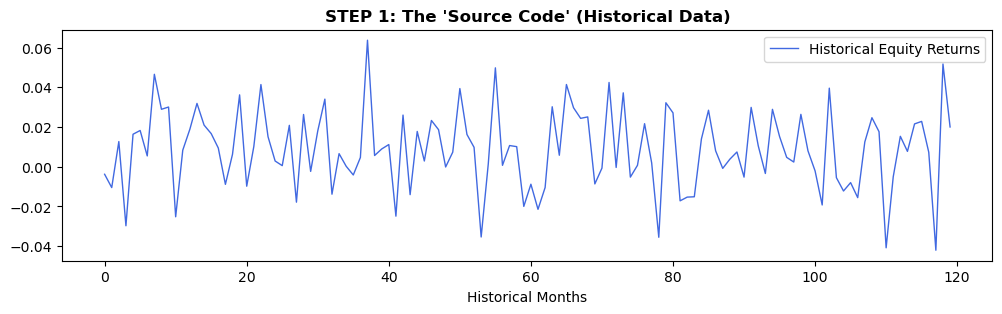

Then we randomly select chunks of returns data with a chosen average block size.



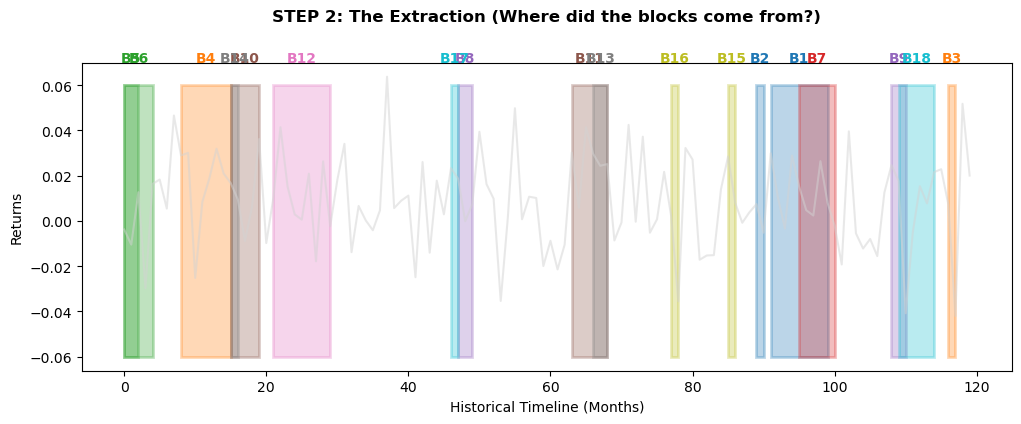

Then, we string these chunks together into a hypothetical price evolution path.



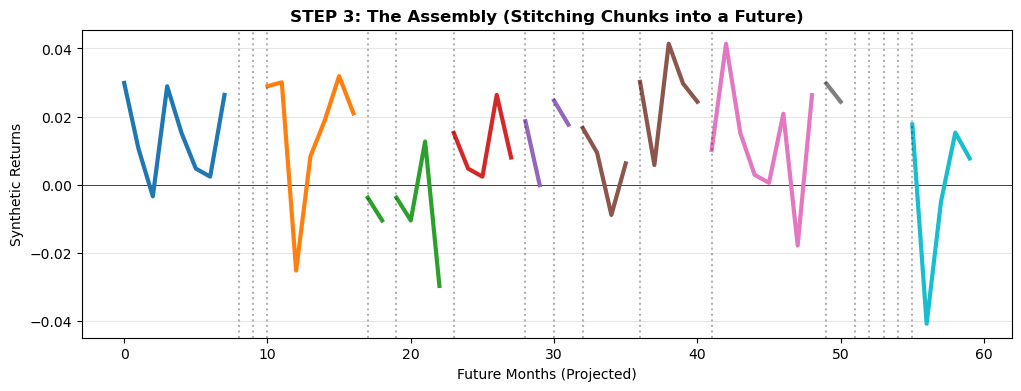

We generate several simulated histories with block-bootstrap to find the median and 5th to 95th percentile range.



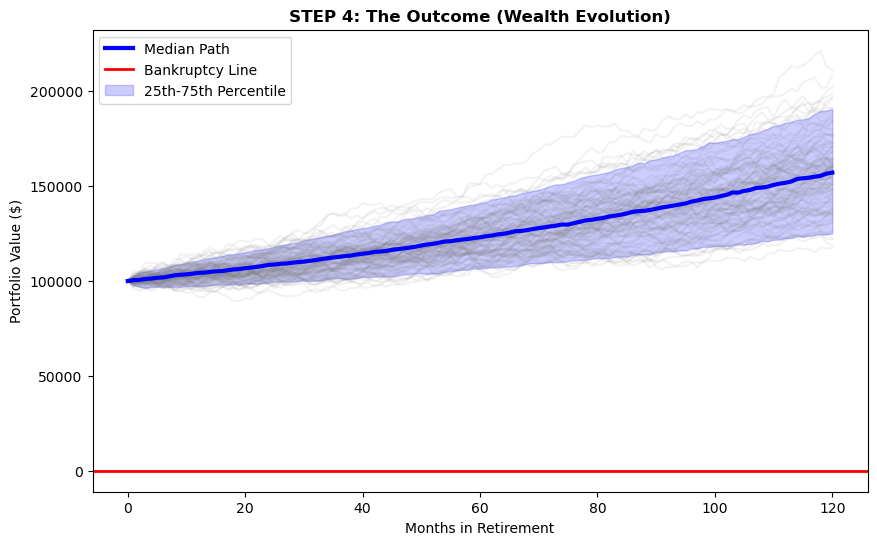

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Setup for professional visual output
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titleweight'] = 'bold'

# =================================================================
# 1. THE SOURCE: 10 Years of "Real" Market History
# =================================================================
# We create a history where assets move together (correlation)
print("First, we start with a historical returns dataset.\n")
np.random.seed(42)
history_len = 120 
mean_ret = [0.007, 0.002] # Equity vs Bonds
cov_mat = [[0.0005, 0.0001], [0.0001, 0.0001]]
history = np.random.multivariate_normal(mean_ret, cov_mat, size=history_len)

fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(history[:, 0], color='royalblue', lw=1, label="Historical Equity Returns")
ax.set_title("STEP 1: The 'Source Code' (Historical Data)")
ax.set_xlabel("Historical Months")
ax.legend()
plt.show()

# %% [markdown]
# ### STEP 2: The Extraction (Sampling Blocks)
# Instead of picking single dots, we pick **sequences**. 
# This preserves the "vibe" of the market (e.g., if month 5 was bad, month 6 was likely also volatile).

# %%
def pedagogical_bootstrap(data, avg_size, target_len):
    path, meta = [], []
    curr = 0
    while curr < target_len:
        start = np.random.randint(0, len(data))
        # Geometric length makes the 'rhythm' of the blocks unpredictable/natural
        length = min(np.random.geometric(1/avg_size), len(data)-start, target_len-curr)
        path.append(data[start : start + length])
        meta.append((start, length, curr))
        curr += length
    return np.vstack(path), meta

target_future = 60
synth_ret, blocks = pedagogical_bootstrap(history, 6, target_future)

# --- VISUALIZING THE EXTRACTION ---
print("Then we randomly select chunks of returns data with a chosen average block size.\n")
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(history[:, 0], color='lightgrey', alpha=0.5)
colors = plt.cm.tab10(np.linspace(0, 1, len(blocks)))

for i, (start, length, _) in enumerate(blocks):
    # Draw a box over the history where the block was 'stolen' from
    rect = patches.Rectangle((start, -0.06), length, 0.12, linewidth=2, 
                             edgecolor=colors[i], facecolor=colors[i], alpha=0.3)
    ax.add_patch(rect)
    ax.text(start + length/2, 0.07, f"B{i+1}", ha='center', color=colors[i], fontweight='bold')
ax.set_title("STEP 2: The Extraction (Where did the blocks come from?)", pad=30)
ax.set_ylabel("Returns")
ax.set_xlabel("Historical Timeline (Months)")
plt.show()

# %% [markdown]
# ### STEP 3: The Assembly (The 'Frankenstein' Path)
# We take those highlighted chunks from above and string them together chronologically 
# to build one possible "Synthetic Future."
print("Then, we string these chunks together into a hypothetical price evolution path.\n")
fig, ax = plt.subplots(figsize=(12, 4))
ax.axhline(0, color='black', lw=0.5)

for i, (start, length, path_pos) in enumerate(blocks):
    chunk = synth_ret[path_pos : path_pos + length, 0]
    ax.plot(range(path_pos, path_pos + length), chunk, color=colors[i], lw=3)
    # Visual connector (the stitch)
    if i > 0:
        ax.axvline(path_pos, color='black', linestyle=':', alpha=0.3)

ax.set_title("STEP 3: The Assembly (Stitching Chunks into a Future)")
ax.set_xlabel("Future Months (Projected)")
ax.set_ylabel("Synthetic Returns")
plt.grid(axis='y', alpha=0.3)
plt.show()

# %% [markdown]
# ### STEP 4: The Outcome (Compounding Wealth)
# Finally, we run this 1,000 times. We apply a **4% withdrawal rule**. 
# Notice how the "Sequence of Returns" (which blocks happen first) determines survival.

print("We generate several simulated histories with block-bootstrap to find the median and 5th to 95th percentile range.\n")
n_sims = 1000
future_months = 120
init_cash = 100_000
withdraw_rate = 0.04 / 12 # Monthly 4% rule
wealth_matrix = np.zeros((n_sims, future_months + 1))
wealth_matrix[:, 0] = init_cash

for s in range(n_sims):
    sim_r, _ = pedagogical_bootstrap(history, 6, future_months)
    w = init_cash
    for t in range(future_months):
        # 60/40 Portfolio return
        ret = (sim_r[t, 0] * 0.6) + (sim_r[t, 1] * 0.4)
        w = (w * (1 + ret)) - (init_cash * withdraw_rate)
        wealth_matrix[s, t+1] = max(w, 0)

# --- FINAL PLOT ---
plt.figure(figsize=(10, 6))
median_path = np.median(wealth_matrix, axis=0)
plt.plot(wealth_matrix[:100].T, color='grey', alpha=0.1) # Plot first 100 for clarity
plt.plot(median_path, color='blue', lw=3, label="Median Path")
plt.axhline(0, color='red', lw=2, label="Bankruptcy Line")
plt.fill_between(range(future_months+1), 
                 np.percentile(wealth_matrix, 5, axis=0), 
                 np.percentile(wealth_matrix, 95, axis=0), 
                 color='blue', alpha=0.2, label="25th-75th Percentile")

plt.title("STEP 4: The Outcome (Wealth Evolution)")
plt.ylabel("Portfolio Value ($)")
plt.xlabel("Months in Retirement")
plt.legend()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import yfinance as yf
from datetime import datetime

# ============================================================================
# PART 1: FETCH REAL HISTORICAL DATA
# ============================================================================

def fetch_sp500_data(ticker='SPY', start_date='2000-01-01'):
    """
    Download S&P 500 historical data and compute monthly returns.
    
    Parameters
    ----------
    ticker : str
        ETF ticker (SPY or VOO)
    start_date : str
        Start date for historical data
        
    Returns
    -------
    pd.Series
        Monthly returns
    """
    print(f"📥 Downloading {ticker} data from {start_date}...")
    data = yf.download(tickers=ticker, start=start_date, auto_adjust=True, progress=False)
    
    # Compute monthly returns by compounding daily returns
    prices = data['Close'].dropna()
    daily_ret = prices.pct_change().dropna()
    monthly_ret = (1 + daily_ret).resample('ME').prod() - 1
    monthly_ret = monthly_ret.dropna()
    
    print(f"✓ Loaded {len(monthly_ret)} months of data")
    print(f"  Mean monthly return: {monthly_ret.mean():.2%}")
    print(f"  Std deviation: {monthly_ret.std():.2%}")
    
    return monthly_ret


# ============================================================================
# PART 2: BLOCK BOOTSTRAP ENGINE
# ============================================================================

def stationary_block_bootstrap(data, avg_block_size, target_length):
    """
    Generate a synthetic return series using stationary block bootstrap.
    
    This method preserves the temporal structure of returns by sampling
    contiguous blocks rather than individual observations.
    
    Parameters
    ----------
    data : array-like
        Historical returns
    avg_block_size : int
        Average length of blocks (in months)
    target_length : int
        Desired length of synthetic series
        
    Returns
    -------
    tuple
        (synthetic_returns, block_metadata)
        block_metadata is a list of (start_idx, length, position) tuples
    """
    data = np.asarray(data)
    synthetic_path = []
    block_info = []
    current_pos = 0
    
    while current_pos < target_length:
        # Random starting point in historical data
        start_idx = np.random.randint(0, len(data))
        
        # Geometric distribution for block length (creates natural variability)
        block_len = np.random.geometric(1 / avg_block_size)
        
        # Don't exceed data boundaries or target length
        block_len = min(block_len, len(data) - start_idx, target_length - current_pos)
        
        # Extract the block
        block = data[start_idx : start_idx + block_len]
        synthetic_path.append(block)
        block_info.append((start_idx, block_len, current_pos))
        
        current_pos += block_len
    
    return np.concatenate(synthetic_path), block_info


# ============================================================================
# PART 3: RETIREMENT SIMULATION ENGINE
# ============================================================================

def simulate_retirement(historical_returns, 
                       n_simulations=1000,
                       years=30,
                       initial_portfolio=1_000_000,
                       withdrawal_rate=0.04,
                       inflation_rate=0.025,
                       avg_block_size=6):
    """
    Run Monte Carlo retirement simulations using block bootstrap.
    
    Parameters
    ----------
    historical_returns : array-like
        Historical monthly returns
    n_simulations : int
        Number of Monte Carlo paths
    years : int
        Retirement horizon in years
    initial_portfolio : float
        Starting portfolio value
    withdrawal_rate : float
        Annual withdrawal rate (e.g., 0.04 = 4%)
    inflation_rate : float
        Annual inflation rate for withdrawal adjustments
    avg_block_size : int
        Average block size for bootstrap (months)
        
    Returns
    -------
    dict
        Results including wealth paths, success rate, and statistics
    """
    months = years * 12
    monthly_withdrawal = initial_portfolio * withdrawal_rate / 12
    monthly_inflation = (1 + inflation_rate) ** (1/12) - 1
    
    # Storage for all simulation paths
    wealth_paths = np.zeros((n_simulations, months + 1))
    wealth_paths[:, 0] = initial_portfolio
    
    print(f"\n🎲 Running {n_simulations:,} simulations...")
    print(f"   Initial portfolio: ${initial_portfolio:,.0f}")
    print(f"   Withdrawal rate: {withdrawal_rate:.1%} annually")
    print(f"   Initial monthly withdrawal: ${monthly_withdrawal:,.0f}")
    print(f"   Inflation adjustment: {inflation_rate:.1%} annually")
    print(f"   Simulation horizon: {years} years ({months} months)")
    
    for sim in range(n_simulations):
        # Generate synthetic return path
        synthetic_returns, _ = stationary_block_bootstrap(
            historical_returns, avg_block_size, months
        )
        
        # Simulate portfolio evolution
        portfolio_value = initial_portfolio
        withdrawal = monthly_withdrawal
        
        for month in range(months):
            # Apply return
            portfolio_value *= (1 + synthetic_returns[month])
            
            # Take withdrawal
            portfolio_value -= withdrawal
            
            # Adjust withdrawal for inflation
            withdrawal *= (1 + monthly_inflation)
            
            # Record (can't go below zero)
            wealth_paths[sim, month + 1] = max(portfolio_value, 0)
            
            # Stop if bankrupt
            if portfolio_value <= 0:
                wealth_paths[sim, month + 1:] = 0
                break
    
    # Calculate statistics
    final_values = wealth_paths[:, -1]
    success_rate = (final_values > 0).mean()
    
    results = {
        'wealth_paths': wealth_paths,
        'final_values': final_values,
        'success_rate': success_rate,
        'median_final': np.median(final_values),
        'p16_final': np.percentile(final_values, 16),
        'p84_final': np.percentile(final_values, 84),
        'median_path': np.median(wealth_paths, axis=0),
        'p16_path': np.percentile(wealth_paths, 16, axis=0),
        'p84_path': np.percentile(wealth_paths, 84, axis=0),
        'p5_path': np.percentile(wealth_paths, 5, axis=0),
        'p95_path': np.percentile(wealth_paths, 95, axis=0),
    }
    
    print(f"\n📊 Simulation Results:")
    print(f"   Success rate: {success_rate:.1%}")
    print(f"   Median final value: ${results['median_final']:,.0f}")
    print(f"   16th percentile: ${results['p16_final']:,.0f}")
    print(f"   84th percentile: ${results['p84_final']:,.0f}")
    
    return results


# ============================================================================
# PART 4: VISUALIZATION
# ============================================================================

def visualize_bootstrap_process(historical_returns, avg_block_size=6):
    """
    Create educational visualization showing how block bootstrap works.
    """
    fig, axes = plt.subplots(3, 1, figsize=(14, 10))
    
    # STEP 1: Show historical data
    ax = axes[0]
    months = np.arange(len(historical_returns))
    ax.plot(months, historical_returns, color='steelblue', linewidth=1.5, alpha=0.8)
    ax.axhline(0, color='black', linewidth=0.5, linestyle='--', alpha=0.3)
    ax.set_title('STEP 1: Historical Returns (The Source Data)', 
                 fontsize=14, fontweight='bold', pad=15)
    ax.set_xlabel('Month')
    ax.set_ylabel('Monthly Return')
    ax.grid(True, alpha=0.3)
    
    # STEP 2: Show block extraction
    ax = axes[1]
    target_len = 60
    synthetic_returns, blocks = stationary_block_bootstrap(
        historical_returns, avg_block_size, target_len
    )
    
    # Plot historical data in grey
    ax.plot(months, historical_returns, color='lightgrey', linewidth=1, alpha=0.5)
    ax.axhline(0, color='black', linewidth=0.5, linestyle='--', alpha=0.3)
    
    # Highlight extracted blocks
    colors = plt.cm.Set3(np.linspace(0, 1, min(len(blocks), 12)))
    
    for i, (start, length, _) in enumerate(blocks[:12]):  # Show first 12 blocks
        color = colors[i % len(colors)]
        # Draw rectangle over the extracted region
        rect = patches.Rectangle(
            (start, -0.15), length, 0.30,
            linewidth=2, edgecolor=color, facecolor=color, alpha=0.3
        )
        ax.add_patch(rect)
        ax.text(start + length/2, 0.18, f'Block {i+1}', 
               ha='center', fontsize=8, color=color, fontweight='bold')
    
    ax.set_title('STEP 2: Block Extraction (Sampling Contiguous Sequences)', 
                 fontsize=14, fontweight='bold', pad=15)
    ax.set_xlabel('Historical Month')
    ax.set_ylabel('Monthly Return')
    ax.set_ylim(-0.2, 0.25)
    ax.grid(True, alpha=0.3)
    
    # STEP 3: Show synthetic path assembly
    ax = axes[2]
    synthetic_months = np.arange(len(synthetic_returns))
    ax.plot(synthetic_months, synthetic_returns, color='darkgreen', linewidth=2)
    ax.axhline(0, color='black', linewidth=0.5, linestyle='--', alpha=0.3)
    
    # Show block boundaries
    for i, (_, _, pos) in enumerate(blocks[:-1]):
        next_pos = blocks[i + 1][2]
        ax.axvline(next_pos, color='red', linestyle=':', alpha=0.4, linewidth=1)
    
    ax.set_title('STEP 3: Synthetic Path (Stitching Blocks Together)', 
                 fontsize=14, fontweight='bold', pad=15)
    ax.set_xlabel('Synthetic Future Month')
    ax.set_ylabel('Monthly Return')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def plot_simulation_results(results, years, withdrawal_rate, inflation_rate):
    """
    Create comprehensive visualization of simulation results.
    """
    months = results['wealth_paths'].shape[1]
    time_axis = np.arange(months) / 12  # Convert to years
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot 1: Wealth trajectories with percentiles
    ax = axes[0, 0]
    # Show sample paths
    sample_paths = np.random.choice(len(results['wealth_paths']), 100, replace=False)
    for i in sample_paths:
        ax.plot(time_axis, results['wealth_paths'][i], 
               color='grey', alpha=0.05, linewidth=0.5)
    
    # Plot median and percentile bands
    ax.plot(time_axis, results['median_path'], 
           color='darkblue', linewidth=3, label='Median', zorder=10)
    ax.fill_between(time_axis, results['p16_path'], results['p84_path'],
                    color='blue', alpha=0.3, label='16th-84th percentile (68%)')
    ax.fill_between(time_axis, results['p5_path'], results['p95_path'],
                    color='blue', alpha=0.15, label='5th-95th percentile (90%)')
    ax.axhline(0, color='red', linewidth=2, linestyle='--', label='Bankruptcy')
    
    ax.set_title('Portfolio Value Evolution', fontsize=13, fontweight='bold')
    ax.set_xlabel('Years in Retirement')
    ax.set_ylabel('Portfolio Value ($)')
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M'))
    
    # Plot 2: Distribution of final values
    ax = axes[0, 1]
    final_values = results['final_values']
    ax.hist(final_values[final_values > 0], bins=50, 
           color='steelblue', alpha=0.7, edgecolor='black')
    ax.axvline(results['median_final'], color='darkblue', 
              linewidth=2, linestyle='--', label=f"Median: ${results['median_final']/1e6:.2f}M")
    ax.axvline(results['p16_final'], color='orange', 
              linewidth=2, linestyle='--', label=f"16th %ile: ${results['p16_final']/1e6:.2f}M")
    ax.axvline(results['p84_final'], color='green', 
              linewidth=2, linestyle='--', label=f"84th %ile: ${results['p84_final']/1e6:.2f}M")
    
    ax.set_title('Distribution of Final Portfolio Values', fontsize=13, fontweight='bold')
    ax.set_xlabel('Final Portfolio Value ($)')
    ax.set_ylabel('Frequency')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3, axis='y')
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M'))
    
    # Plot 3: Success rate over time
    ax = axes[1, 0]
    survival_rates = (results['wealth_paths'] > 0).mean(axis=0)
    ax.plot(time_axis, survival_rates * 100, color='darkgreen', linewidth=2.5)
    ax.fill_between(time_axis, 0, survival_rates * 100, color='green', alpha=0.2)
    ax.axhline(90, color='orange', linestyle='--', linewidth=1.5, alpha=0.7, label='90% threshold')
    ax.axhline(95, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='95% threshold')
    
    ax.set_title('Portfolio Survival Rate Over Time', fontsize=13, fontweight='bold')
    ax.set_xlabel('Years in Retirement')
    ax.set_ylabel('Survival Rate (%)')
    ax.set_ylim([0, 105])
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    
    # Plot 4: Summary statistics
    ax = axes[1, 1]
    ax.axis('off')
    
    summary_text = f"""
    SIMULATION SUMMARY
    {'='*50}
    
    Withdrawal Strategy:
    • Annual withdrawal rate: {withdrawal_rate:.1%}
    • Inflation adjustment: {inflation_rate:.1%} annually
    • Time horizon: {years} years
    
    Outcomes:
    • Success rate: {results['success_rate']:.1%}
    • Median final value: ${results['median_final']:,.0f}
    • 16th percentile: ${results['p16_final']:,.0f}
    • 84th percentile: ${results['p84_final']:,.0f}
    
    Interpretation:
    • {results['success_rate']:.0%} of simulations ended with money
    • 68% of outcomes fall between P16 and P84
    • Lower percentiles show downside risk
    • Higher percentiles show upside potential
    """
    
    ax.text(0.1, 0.5, summary_text, fontsize=11, family='monospace',
           verticalalignment='center', bbox=dict(boxstyle='round', 
           facecolor='wheat', alpha=0.3))
    
    plt.tight_layout()
    plt.show()


# ============================================================================
# PART 5: MAIN TEST CASE
# ============================================================================

print("="*70)
print("RETIREMENT PORTFOLIO SIMULATION WITH BLOCK BOOTSTRAP")
print("="*70)

# Fetch S&P 500 data
sp500_returns = fetch_sp500_data('SPY', start_date='2000-01-01')

# Visualize the bootstrap process
print("\n" + "="*70)
print("VISUALIZING THE BLOCK BOOTSTRAP METHOD")
print("="*70)
visualize_bootstrap_process(sp500_returns.values, avg_block_size=6)

# Test Case 1: 4% withdrawal rate
print("\n" + "="*70)
print("TEST CASE 1: 4% Withdrawal Rate with 2.5% Inflation")
print("="*70)
results_4pct = simulate_retirement(
    historical_returns=sp500_returns.values,
    n_simulations=1000,
    years=30,
    initial_portfolio=1_000_000,
    withdrawal_rate=0.04,
    inflation_rate=0.025,
    avg_block_size=6
)
plot_simulation_results(results_4pct, years=30, 
                        withdrawal_rate=0.04, inflation_rate=0.025)

# Test Case 2: 2.5% withdrawal rate (more conservative)
print("\n" + "="*70)
print("TEST CASE 2: 2.5% Withdrawal Rate with 2.5% Inflation")
print("="*70)
results_25pct = simulate_retirement(
    historical_returns=sp500_returns.values,
    n_simulations=1000,
    years=30,
    initial_portfolio=1_000_000,
    withdrawal_rate=0.025,
    inflation_rate=0.025,
    avg_block_size=6
)
plot_simulation_results(results_25pct, years=30, 
                        withdrawal_rate=0.025, inflation_rate=0.025)

print("\n" + "="*70)
print("SIMULATION COMPLETE!")
print("="*70)

RETIREMENT PORTFOLIO SIMULATION WITH BLOCK BOOTSTRAP
📥 Downloading SPY data from 2000-01-01...


TypeError: download() missing 1 required positional argument: 'tickers'